In [2]:
!pip install -q tensorflow-recommenders==0.7.3

In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import numpy as np

import os
import tempfile

import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

## Prepare Data

In [4]:
# load dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

In [5]:
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"],
})
movies = movies.map(lambda x: x["movie_title"])

In [6]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(min_timestamp, max_timestamp, num=1000)

unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1000).map(lambda x: x["user_id"]))))

In [7]:
unique_user_ids.shape

(943,)

## Model

### Query Tower

In [8]:
class UserModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
        ])

        self.timestamp_embedding = tf.keras.Sequential([
            tf.keras.layers.Discretization(timestamp_buckets.tolist()),
            tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
        ])

        self.normalized_timestamp = tf.keras.layers.Normalization(axis=None)
        self.normalized_timestamp.adapt(timestamps)

    def call(self, inputs):
        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.timestamp_embedding(inputs["timestamp"]),
            tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1))
        ], axis=1)

class QueryModel(tf.keras.Model):

    def __init__(self, layer_sizes):

        super().__init__()

        self.embedding_model = UserModel() #QueryModel.embedding_model.normalized_timestamp.adapt(timestamps)

        self.dense_layers = tf.keras.Sequential()
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

### Candidate Tower

In [9]:
class MovieModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        max_tokens = 10000

        self.title_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_movie_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32),
        ])

        self.title_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens)


        self.title_text_embedding = tf.keras.Sequential([
            self.title_vectorizer,
            tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
            tf.keras.layers.GlobalAveragePooling1D(),
        ])

        self.title_vectorizer.adapt(movies)

    def call(self, titles):
        return tf.concat([
            self.title_embedding(titles),
            self.title_text_embedding(titles),
        ], axis=1)

class CandidateModel(tf.keras.Model):

    def __init__(self, layer_sizes):
        super().__init__()

        self.embedding_model = MovieModel()

        self.dense_layers = tf.keras.Sequential()

        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

### Combined Model

In [10]:
class TwoTowerModel(tfrs.models.Model):

    def __init__(self, layer_sizes):
        super().__init__()

        self.query_model = QueryModel(layer_sizes)
        self.candidate_model = CandidateModel(layer_sizes)
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(self.candidate_model),
            ),
        )

    def compute_loss(self, features, training=False):
        query_embeddings = self.query_model({
            "user_id": features["user_id"],
            "timestamp": features["timestamp"],
        })
        movie_embeddings = self.candidate_model(features["movie_title"])

        return self.task(query_embeddings, movie_embeddings, compute_metrics=not training)

## Training

In [11]:
tf.random.set_seed(42)

shuffled = ratings.shuffle(100000, seed=42, reshuffle_each_iteration=False)
train = shuffled.take(80000)
test = shuffled.skip(80000).take(20000)

cached_train = train.shuffle(100000).batch(2048)
cached_test = test.batch(4096).cache()

In [12]:
num_epochs = 300

model = TwoTowerModel([64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history = model.fit(
    cached_train,
    validation_data = cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0
)

<ipython-input-13-00e59b8712f9>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


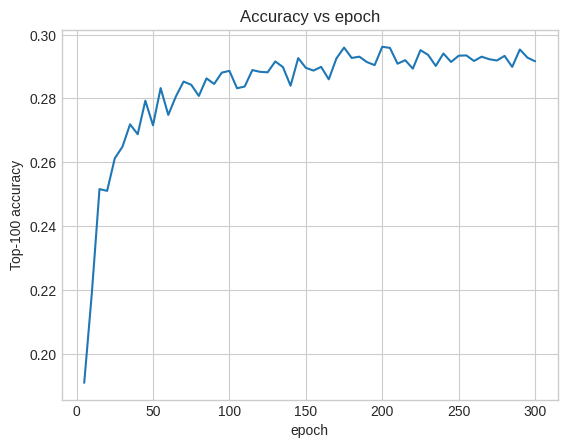

In [13]:
num_validation_runs = len(history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, history.history["val_factorized_top_k/top_100_categorical_accuracy"])
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()